# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [37]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from icecream import ic

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int32(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def nms(Ig, Ior):
    """ Array**2 -> Array """
    n, m = Ig.shape
    Ig_copy = np.zeros_like(Ig)
    for i in range(1, n-1):
        for j in range(1, m-1):
            if Ior[i,j] == 1:
                local = Ig[i,j-1:j+2]
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 2:
                local = np.array([Ig[i-1,j-1], Ig[i, j], Ig[i+1, j+1]])
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 3:
                local = Ig[i-1:i+2, j]
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 4:
                local = np.array([Ig[i+1,j-1], Ig[i, j], Ig[i-1, j+1]])
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
    return Ig_copy

h_sobel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [47]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    # Directionnal derivate 
    I_x = convolve2d(image, h_sobel, boundary='symm') # avec padding copy
    I_y = convolve2d(image, h_sobel.T, boundary='symm')

    # Computation of the product
    I_x2 = I_x**2
    I_y2 = I_y**2
    I_xI_y = I_x*I_y

    # Convolution w/ gaussianKernel
    N = (1/3) * (int(0.5*(scale-1)))
    w = gaussianKernel(N)
    I_x2 = convolve2d(I_x2, w, mode='same') # Sans padding 
    I_y2 = convolve2d(I_y2, w, mode='same')
    I_xI_y = convolve2d(I_xI_y, w, mode="same")
    
    # Computation of det and return
    M = np.array([[I_x2, I_xI_y], [I_xI_y, I_y2]])
    det = M[0,0]*M[1,1] - M[1,0]*M[0,1]
    return det - kappa * np.trace(M)**2

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

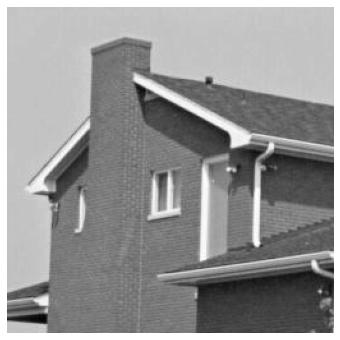

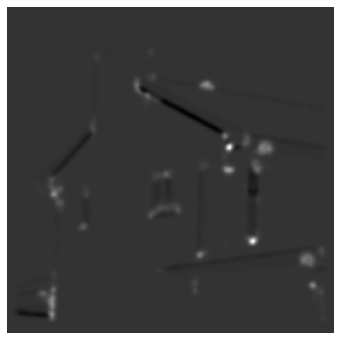

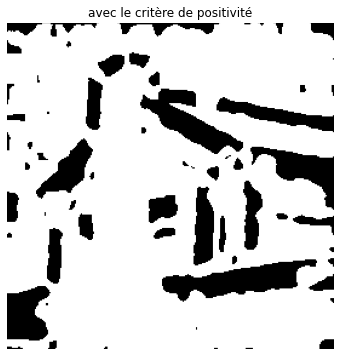

In [51]:
def to_disp_harris_R(R):
    R_copy = R.copy()
    return np.where(R_copy>0, 1, 0)
house = np.array(Image.open('./img/house2.png'))
harris_house = computeR(house, 15, 0.04)
imshow(house)
imshow(harris_house)
imshow(to_disp_harris_R(harris_house), "avec le critère de positivité")

**Il manque l'étape local maxima pour faire fonctionner le critère de positivité pour les coins**

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [160]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R>thres, 1, 0)

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [161]:
def rnms(image_harris, R_bin):
    """ Array[n, m] -> Array[n, m] 
    """
    R = image_harris
    n, m = R.shape
    R_copy = np.zeros_like(R)
    for i in range(1, n-1):
        for j in range(1, m-1):
            neighborhood = R[i-1:i+2, j-1:j+2]
            neigh_max = np.max(neighborhood)
            # count_max = np.where(neighborhood==neigh_max, 1, 0).sum()
            # ic(count_max)
            if R[i,j] == neigh_max and R_bin[i,j] == 1: # and count_max == 1:
                R_copy[i,j] = 1
    return R_copy

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [162]:
def cornerDetector(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, scale, kappa)
    R = rnms(R, thresholdR(R, thres*R.max()))
    return R

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

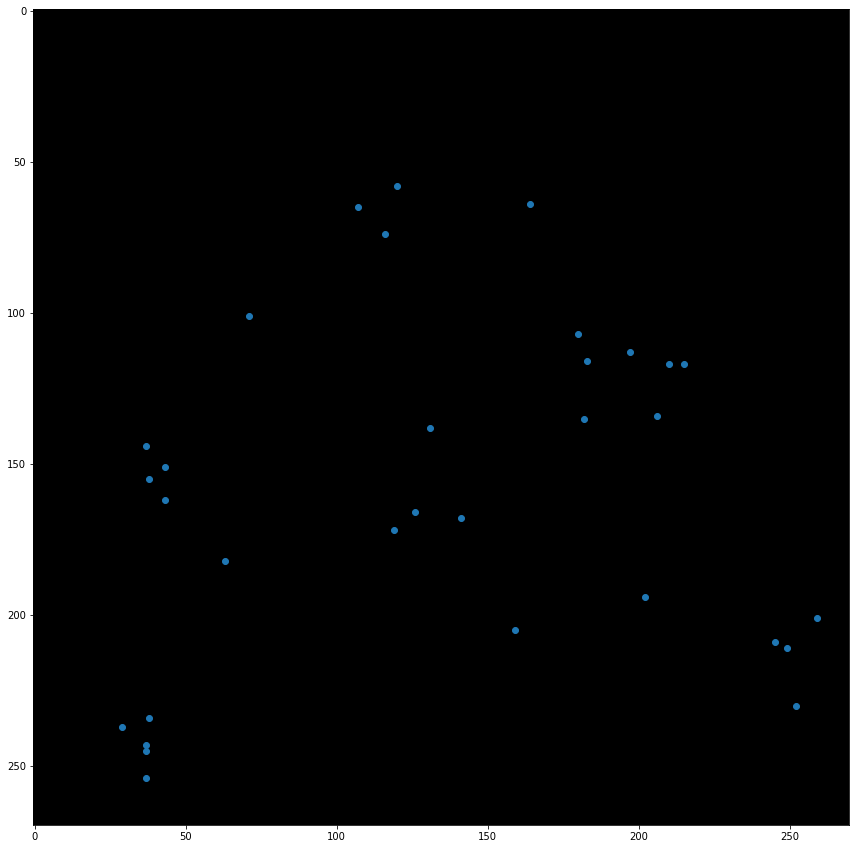

In [168]:
Cmap = cornerDetector(house, 15 , 0.04, 0.1)
fig, ax = plt.subplots(figsize=(20,15))
ax.imshow(house)
ax.imshow(Cmap)
ax.scatter(*np.nonzero(Cmap.T))
Cmap

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

2) What are the dynamic ranges of these two images ?

Your answer...

3) What are the transformations beetween the two images ?

Your answer...

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Your Answer